# Spam Classifier

In [1]:
import tarfile
import numpy as np
import email
import email.policy
from urllib.request import urlretrieve

## 1. Get the data

Download the compressed files from the Apache SpamAssassin’s public datasets, store them in the _Data_ folder and return the list of the decompressed e-mails.

In [2]:
def download_and_unzip_content(filename):
    
    files_arr = []     # array of mails
    path = 'Data/'

    # load and unzip the compressed files
    try:               
        tar = tarfile.open(path+filename)
        print('Number of files {}.'.format(len(tar.getmembers()[1:])))

        for file in tar.getmembers()[1:]:
            f = tar.extractfile(file)
            content = f.read()
            f.close()
            text = email.parser.BytesParser(policy=email.policy.default).parsebytes(content)
            files_arr.append(text)

        tar.close()
        return files_arr
 
    # download the files is needed
    except FileNotFoundError:    
        print('File not found. Downloading it.')
        url = 'https://spamassassin.apache.org/old/publiccorpus/'
        urlretrieve(url+filename, path+filename)
        download_and_unzip_content(filename)
        
        

easy_ham = download_and_unzip_content("20021010_easy_ham.tar.bz2")
hard_ham = download_and_unzip_content("20021010_hard_ham.tar.bz2")
spam = download_and_unzip_content("20021010_spam.tar.bz2")

Number of files 2551.
Number of files 250.
Number of files 501.



## 2. Preprocessing and Analysis

### 2.1 Train test split
 Before performing any analysis we split the e-mails into a train and test set. Instead of using the function `train_test_split` from `sklearn.model_selection` we define a custom one.

In [3]:
def split_train_test_set(ratio, spam, ham1, ham2, seed = 42):
    
    print("The output is the following: X_train, X_test, y_train, y_test.")
    print("1: spam, 0: ham.")
    
    # Split easy/hard ham and spam into train and test datsets
    X_train_spam = spam[int(ratio*len(spam)):]
    X_train_ham1 = ham1[int(ratio*len(ham1)):]
    X_train_ham2 = ham2[int(ratio*len(ham2)):]
    
    X_test_spam = spam[:int(ratio*len(spam))]
    X_test_ham1 = ham1[:int(ratio*len(ham1))]
    X_test_ham2 = ham2[:int(ratio*len(ham2))]
    
    # Join the train and test datsets
    X_train = np.array(X_train_spam + X_train_ham1 + X_train_ham2)
    X_test = np.array(X_test_spam + X_test_ham1 + X_test_ham2)
    
    # Shuffle the datasets
    train_shuffle = np.random.RandomState(seed=seed).permutation(len(X_train))
    test_shuffle = np.random.RandomState(seed=seed).permutation(len(X_test))
    
    # Generate the labels
    y_train = np.concatenate([np.ones(len(X_train_spam)), np.zeros(len(X_train_ham1) + len(X_train_ham2))])
    y_test = np.concatenate([np.ones(len(X_test_spam)), np.zeros(len(X_test_ham1) + len(X_test_ham2))])
    
    return X_train[train_shuffle], X_test[test_shuffle], y_train[train_shuffle], y_test[test_shuffle]
        

Then split the datasets.

In [4]:
X_train, X_test , y_train, y_test = split_train_test_set(.2, spam, easy_ham, hard_ham)

The output is the following: X_train, X_test, y_train, y_test.
1: spam, 0: ham.



### 2.2 Words counting

Let's parse the e-mails' content. 

First, we define a function that parses the html decorators from a the body of an e-mail and returns a string containing its content.

In [5]:
from bs4 import BeautifulSoup

def read_mail(email):
    mail_text = ''
    
    for part in email.walk():
        ctype = part.get_content_type()
        if ctype in ('text/html', 'text/plain'):   
            try: 
                content = part.get_content()
            except:
                content = str(part.get_payload())   
                
            soup = BeautifulSoup(content, 'html.parser')
            mail_text += soup.get_text()
            
    return mail_text

Then, collect the words. 
The following function makes the following parsing operations:

- converts words to lower-case,
- removes punctuation,
- replaces numbers with `NUMBER`,
- replaces urls with `URL`,

It returns the list of all the words of the e-mail.

In [6]:
import re

def collect_words(mail_string):     
    
    re_url1 = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}'
    re_url2 = '|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}'
    re_url3 = '|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    re_url = re_url1+re_url2+re_url3
    
    reg_1 = re.compile(re_url)             # -> Remove ULRs
    reg_2 = re.compile(r'[0-9]+')          # -> Remove numbers
    reg_3 = re.compile(r'[^\w\s]')         # -> Remove punctuation
    reg_4 = re.compile(r'[\n\r\t]')        # -> Remove newlines, tabs, etc..
    
    mail_string = mail_string.lower()      # -> Convert words in lower-case
    mail_string = reg_1.sub("URL", mail_string)
    mail_string = reg_2.sub("NUMBER", mail_string)
    mail_string = reg_3.sub(" ", mail_string)
    mail_string = reg_4.sub(" ", mail_string)
    
    return mail_string.split()

Time to __make a vocabulary with the word frequencies__.
We neglect all the english common words like 'the' or 'a' or 'is'..., that are not useful to classify spam e-mails.

In [7]:
from collections import Counter
from nltk.corpus import stopwords

def make_dict(mail_set, rm_comm_eng_words, subj_dict=False): 
    dictionary = Counter()
    
    # if true makes a dictionary with the most common words of the subject
    if subj_dict:
        for mail in mail_set:
            subj_string = str(mail['Subject'])
            dictionary += Counter(collect_words(subj_string))
    
    # make a dictionary with the most common body words
    else:
        for mail in mail_set:
            dictionary += Counter(collect_words(read_mail(mail))) 
    
    # Remove the English most common words
    single_letters = ['e','c','x','g','p','r','n','f','u','l','a','i']
    for letter in single_letters:
        del dictionary[letter]
    
    if rm_comm_eng_words:
        common_words = np.array(stopwords.words('english'))
        for word in common_words:
            del dictionary[word]
     
    return dictionary

Generate __3 different vocabnularies__: 

- ham words, 
- spam words,
- suject words from spam.

The following function generates the vocabulary via the `make_dict` function, it saves it in a `.txt` file.
Finally, it loads the list of the `n_words` most common words.  

In [8]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='bs4')    # shut up bs4 URL warning


def most_common_words(n_words, txt_file, words_set=X_train, rm_comm_eng_words=True, subj_dict=False,):
    
    # try to load the dictionary from the .txt file.
    try:
        body_dict = []
        file = open(txt_file, 'r')
        
        for line in range(n_words):
            body_dict.append(file.readline().rstrip())
        
        file.close()
        body_dict = np.array(body_dict)
        print('Dictionary loaded.')
    
    # make_dict if the .txt doesn't exists
    except FileNotFoundError:
        print("There's no dictionary. Creating a new one.")
        body_dict = make_dict(words_set, subj_dict=subj_dict, rm_comm_eng_words=rm_comm_eng_words)
        body_dict = body_dict.most_common()
        file = open(txt_file, 'w+')
        
        for key, freq in body_dict:
            file.write(str(key)+'\n')
        
        file.close()
        body_dict = most_common_words(n_words, txt_file, rm_comm_eng_words)
    
    return body_dict



spam_subj_words = most_common_words(50,'vocabularies/spam_subj_dict.txt', words_set=X_train[y_train==1], subj_dict=True)
ham_words = most_common_words(200, 'vocabularies/ham_dict.txt', words_set=X_train[y_train==0])
spam_words = most_common_words(250, 'vocabularies/spam_dict.txt', words_set=X_train[y_train==1])

Dictionary loaded.
Dictionary loaded.
Dictionary loaded.


Here's the 20 most common ham and spam words:

In [9]:
from pandas import Series,DataFrame

ham_spam = DataFrame({'Ham': ham_words[:20], 'Spam': spam_words[:20]})
ham_spam.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Ham,NUMBER,URL,com,font,list,new,get,one,use,time,like,would,color,net,linux,mail,also,people,date,world
Spam,NUMBER,free,URL,mv,money,email,mail,please,get,list,business,people,click,information,one,name,time,us,new,receive


Good, words like __free__, __money__ or __please__ looks like typical spammy words. 
Now a look to the 10 most frequent spam subject words:

In [10]:
from pandas import Series,DataFrame

subj_spam = DataFrame({'Subj': spam_subj_words[:20]})
subj_spam.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Subj,NUMBER,ilug,free,adv,rates,get,home,money,best,systemworks,new,low,year,social,clearance,zzzz,one,insurance,mortgage,online


### 2.3 Email type

Now take a look at how the emails are constructed. Many mails consists in multipart:

In [11]:
def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = email.get_content_type()
        structures[structure] += 1
    return structures

Here's the different e-mail types:

In [12]:
ham_ser = Series(dict(structures_counter(X_train[y_train==0])))
spam_ser = Series(dict(structures_counter(X_train[y_train==1])))

struct_df = DataFrame({'Ham':ham_ser, 'Spam':spam_ser})
struct_df.transpose()

,multipart/alternative,multipart/mixed,multipart/related,multipart/report,multipart/signed,text/html,text/plain
Ham,40.0,12.0,3.0,1.0,55.0,94.0,2036.0
Spam,36.0,34.0,8.0,NaN,NaN,144.0,179.0


Looks like a good feature to have. 
There's a lot of `plain text` in the ham dataset, while `html` is more frequent in the spam one.

Let's save the different `email_types`s in the `category` list for later use.

In [13]:
email_structures = structures_counter(X_train)
categories = np.array([key for (key, word) in email_structures.most_common()], dtype='<U13')
categories = np.sort(categories)


## 3. Generating the Features

Now convert our features into a vector.
We define two new classes, `DigitalizeMail` and `SelectFeatures`. 

The `transform()` method of  `DigitalizeMail`, create the feature vector.
For each mail it sotres:

- the frequency of the 200 most common ham words
- the frequency of the 250 most common spam words
- the frequency of the 50 most common subject words
- the e-mail type

However there are a lot of common words in the  ham and spam vocabulary. Therefore the feature vector has many repeated entries.
To avoid repetitions and reduce the risk of overfitting, we use `SelectFeatures` that chooses only a subset of the features vector and takes care of avoiding repetitions. 
The total number of features is treated as a hyper-parameter. It is different for each trained classifier (see below).


In [14]:
# Generate the feature vectors
def vectorize(mail, dictionary, n_words, subject=False):
    freq_vec = np.zeros(n_words)
    mail_words = make_dict([mail], subj_dict=subject, rm_comm_eng_words=False)
    
    for index, key in list(enumerate(dictionary[:n_words])):
        freq_vec[index] = mail_words[key]
    
    return freq_vec

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

# make the feature vector
class DigitalizeMail(BaseEstimator, TransformerMixin):
    
    def __init__(self, ham_dict, spam_dict, subj_dict): 
        self.ham_dict = ham_dict
        self.spam_dict = spam_dict
        self.subj_dict = subj_dict
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        ham_vec = np.zeros((len(X), 200))
        spam_vec = np.zeros((len(X), 250))
        subj_dict_vec = np.zeros((len(X), 50))
        email_type = np.zeros((len(X), 1), dtype='<U13')
        
        for index, mail in enumerate(X):
            ham_vec[index] = vectorize(mail, self.ham_dict, 200)
            spam_vec[index] = vectorize(mail, self.spam_dict, 250)
            subj_dict_vec[index] = vectorize(mail, self.subj_dict, 50, subject=True)
            email_type[index] = mail.get_content_type()
            
        return np.concatenate([ham_vec, spam_vec, subj_dict_vec, email_type], axis=1)
        

# choose only a subset of the total features    
class SelectFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, ham_dict, spam_dict, subj_dict, spam_ham_ratio, n_subj_words): 
        self.ham_dict = ham_dict
        self.spam_dict = spam_dict
        self.subj_dict = subj_dict
        self.spam_ham_ratio = spam_ham_ratio
        self.n_subj_words = n_subj_words
        self.total_features = np.concatenate([ham_words,spam_words,spam_subj_words, categories])
   
    def fit(self, X, y=None):
        count, index = 0, 0
        spam = []
        
        # make a list of len=spam_ham_ratio containing most common spammy words not in 200 most common ham words
        while(count<self.spam_ham_ratio)and(index<len(self.spam_dict)):
            if self.spam_dict[index] not in self.ham_dict[:200]:
                spam.append(self.spam_dict[index])
                count +=1
            index +=1

        self.args = [np.argwhere(self.spam_dict==el) for el in spam]
        self.args = np.array(self.args).flatten()+200
        self.body_dict = np.concatenate([self.ham_dict[:200-self.spam_ham_ratio], spam])
        
        # List with the reduced set of features
        self.red_feat_list = np.concatenate([list(range(200-self.spam_ham_ratio)), 
                                             self.args, 
                                             list(range(450, 450+self.n_subj_words)),
                                             list(range(500,500+len(categories)))])
        
        #self.red_words_list = np.concatenate([ham_words_m, spam_words_m, subj_words_m], axis=1)
        #self.red_feat_list = np.concatenate([self.red_words_list, categories], axis=1)
        
        return self

    
    def transform(self, X, y=None):
        ham_words_m = X[:, :200-self.spam_ham_ratio]
        spam_words_m = X[:, self.args]
        subj_words_m = X[:, 450:450+self.n_subj_words]
        email_type_m = X[:, -1]
        return np.concatenate([ham_words_m, spam_words_m, subj_words_m,
                               email_type_m.reshape((len(X), 1))], axis=1)
        


### 3.1 Automatising the process

First preprocessing.

Make the `X_train_prepared` matrix of the train dataset with all the possibile features.

In [16]:
X_train_prepared = DigitalizeMail(ham_dict=ham_words, 
                                  spam_dict=spam_words, 
                                  subj_dict=spam_subj_words).fit_transform(X_train)
X_train_prepared.shape

(2642, 501)

Second preprocessing.

Create the `Pipeline` that __selects the features for each classifier__. We use  `OneHotEcoder` to deal with the _categorical_ `email_type`.

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

preprocessing = ColumnTransformer([
    ('num', StandardScaler(), slice(0,-1)),
    ('cat', OneHotEncoder(categories=[categories]), [-1])
])


feat_sel = Pipeline([
    ('select_features', SelectFeatures(ham_dict=ham_words,spam_dict=spam_words, 
                                       subj_dict=spam_subj_words, spam_ham_ratio=35, n_subj_words=10)),
    ('preprocess', preprocessing )
    ])



## 4. Train some model

Let's train some classifier. 
We train 5 different modelf that work with different algorithms, to see the best one.
We will merge some of them into a __voting classifier__.


### 4.1 Dumb Model -- everything is ham

Set a reference for the sccuracy score. 

In [18]:
X_train_ham = X_train[y_train == 0]
len(X_train_ham) / len(X_train)

0.848221044663134

The accuracy of the simplest classifier is quite high. 

Therefore we use the __f1 score__ to evaluate the performances of the trained classifers.
Use `cross_val_score` splitting the train dataset in 5 subsets. 

In [19]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

def print_scores(clf_cv, acc=True, prec=True, rec=True):
    if acc:
        print('accuracy: %.3f' % clf_cv['test_accuracy_score'].mean())
    if prec:
        print('precision: %.3f' % clf_cv['test_precision_score'].mean())
    if rec:
        print('recall: %.3f' % clf_cv['test_recall_score'].mean())
    

### 4.2 Logistic Regression

Simple Linear Model. 

In [20]:
from sklearn.linear_model import LogisticRegression

log_reg = Pipeline([
    ('pre', feat_sel),
    ('reg', LogisticRegression(solver='liblinear', random_state=42))
])

lin_cv = cross_validate(log_reg, X_train_prepared, y_train, cv=5, scoring=scorers, n_jobs=-1)
print_scores(lin_cv)

accuracy: 0.967
precision: 0.902
recall: 0.878


Fine tune some hyperparameter (including the features selection).

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, reciprocal

param_distrib = {'reg__penalty': ['l2', 'l1'], 
                 "reg__C":uniform(.1, 20),
                 "pre__select_features__spam_ham_ratio":list(range(5, 35)),
                 "pre__select_features__n_subj_words": list(range(5, 50))}

rnd_srch_log = RandomizedSearchCV(log_reg, param_distributions=param_distrib, cv=5, scoring='f1', 
                                  random_state=42, n_iter=100, n_jobs=-1, verbose=5,)

rnd_srch_log.fit(X_train_prepared, y_train)

print('Best score: %.3f' % rnd_srch_log.best_score_)
print('Best params:', rnd_srch_log.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.6min finished


Best score: 0.899
Best params: {'pre__select_features__n_subj_words': 7, 'pre__select_features__spam_ham_ratio': 9, 'reg__C': 12.250897038028766, 'reg__penalty': 'l2'}


Evaluate the performances of the fine tuned algorithm.

In [22]:
log_reg = rnd_srch_log.best_estimator_

lin_cv = cross_validate(log_reg, X_train_prepared, y_train, cv=5, scoring=scorers, n_jobs=-1)
print_scores(lin_cv)

accuracy: 0.969
precision: 0.887
recall: 0.913


### 4.3 SGD Classifier

Another kind of linear model|.

In [23]:
from sklearn.linear_model import SGDClassifier

sgd_clf = Pipeline([
    ('pre', feat_sel),
    ('sgd', SGDClassifier(loss="log", random_state=42))
])

sgd_cv = cross_validate(sgd_clf, X_train_prepared, y_train, cv=5, scoring=scorers, n_jobs=-1)
print_scores(sgd_cv)

accuracy: 0.963
precision: 0.927
recall: 0.826


Fine tune some hyperparameter (including the features selection).

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, reciprocal

param_distrib = {"sgd__loss": ['hinge', 'log','squared_hinge'], 'sgd__alpha': reciprocal(.0001, 1),
                 "pre__select_features__spam_ham_ratio":list(range(5, 35)),
                 "pre__select_features__n_subj_words": list(range(5, 50))}

rnd_srch_sgd = RandomizedSearchCV(sgd_clf, param_distributions=param_distrib, 
                                  cv=5, scoring='f1', random_state=42,
                                  n_iter=100, verbose=3, n_jobs=-1)

rnd_srch_sgd.fit(X_train_prepared, y_train)

print('Best score: %.3f' % rnd_srch_sgd.best_score_)
print('Best params:', rnd_srch_sgd.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished


Best score: 0.875
Best params: {'pre__select_features__n_subj_words': 9, 'pre__select_features__spam_ham_ratio': 14, 'sgd__alpha': 0.002715581955282939, 'sgd__loss': 'hinge'}


Evaluate the performances of the fine tuned algorithm.

In [25]:
sgd_clf = rnd_srch_sgd.best_estimator_

sgd_cv = cross_validate(sgd_clf, X_train_prepared, y_train, cv=5, scoring=scorers, n_jobs=-1)
print_scores(sgd_cv)

accuracy: 0.964
precision: 0.936
recall: 0.826


### 4.4 RandomForestClassifier

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = Pipeline([
    ('pre', feat_sel),
    ('rnd', RandomForestClassifier(random_state=42))
])


forest_cv = cross_validate(forest_clf, X_train_prepared, y_train, cv=5, scoring=scorers, n_jobs=-1)
print_scores(forest_cv)

accuracy: 0.965
precision: 0.932
recall: 0.831


Good permonances! Now fine tune some hyperparameter (including the features selection).

In [27]:
param_distrib = {"rnd__n_estimators": list(range(1,500)), "rnd__max_depth": reciprocal(2,100),
                 "pre__select_features__spam_ham_ratio":list(range(5, 35)),
                 "pre__select_features__n_subj_words": list(range(5, 50))}

rnd_srch_forest = RandomizedSearchCV(forest_clf, param_distributions=param_distrib,
                                     cv=5, scoring='f1', random_state=42,
                                     n_iter=100, verbose=5, n_jobs=-1)

rnd_srch_forest.fit(X_train_prepared, y_train)

print('Best score: %.3f' % rnd_srch_forest.best_score_)
print('Best params:', rnd_srch_forest.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.3min finished


Best score: 0.930
Best params: {'pre__select_features__n_subj_words': 35, 'pre__select_features__spam_ham_ratio': 7, 'rnd__max_depth': 92.59423558429536, 'rnd__n_estimators': 116}


Evaluate the performances of the fine tuned algorithm.

In [28]:
forest_clf = rnd_srch_forest.best_estimator_

forest_cv = cross_validate(forest_clf, X_train_prepared, y_train, cv=5, scoring=scorers, n_jobs=-1)
print_scores(forest_cv)

accuracy: 0.980
precision: 0.956
recall: 0.908


Great performances! This is the best classifier.

### 4.5 KNCLassifier

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn_clf = Pipeline([
    ('pre', feat_sel),
    ('knn', KNeighborsClassifier())
])


knn_cv = cross_validate(knn_clf, X_train_prepared, y_train, cv=5, scoring=scorers, n_jobs=-1)
print_scores(knn_cv)

accuracy: 0.937
precision: 0.843
recall: 0.721


Poor perfomances. Let's see if we can get better.

In [30]:
param_distrib = {"knn__n_neighbors": list(range(1, 10)), 
                 "knn__weights": ['uniform', 'distance'], 
                 "knn__leaf_size": list(range(20, 50)),
                 "pre__select_features__spam_ham_ratio":list(range(5, 35)),
                 "pre__select_features__n_subj_words": list(range(5, 50))}

rnd_srch_knn = RandomizedSearchCV(knn_clf, param_distributions=param_distrib,
                                     cv=5, scoring='f1', random_state=42,
                                     n_iter=100, verbose=5, n_jobs=-1)

rnd_srch_knn.fit(X_train_prepared, y_train)

print('Best score: %.3f' % rnd_srch_knn.best_score_)
print('Best params:', rnd_srch_knn.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished


Best score: 0.848
Best params: {'pre__select_features__spam_ham_ratio': 22, 'pre__select_features__n_subj_words': 19, 'knn__weights': 'distance', 'knn__n_neighbors': 4, 'knn__leaf_size': 47}


Evaluate the performances of the fine tuned algorithm.

In [31]:
knn_clf = rnd_srch_knn.best_estimator_

knn_cv = cross_validate(knn_clf, X_train_prepared, y_train, cv=5, scoring=scorers, n_jobs=-1)
print_scores(knn_cv)

accuracy: 0.955
precision: 0.872
recall: 0.828


Still very poor precision.

### 4.6 Support Vector Machine

In [32]:
from sklearn.svm import SVC

svc_clf = Pipeline([
    ('pre', feat_sel),
    ('svc', SVC())
])

svc_cv = cross_validate(svc_clf, X_train_prepared, y_train, cv=5, scoring=scorers, n_jobs=-1)
print_scores(svc_cv)

accuracy: 0.961
precision: 0.946
recall: 0.788


Fine tune some hyperparameter (including the features selection).

In [33]:
param_distrib = {'svc__kernel': ['rbf', 'poly'],
                 'svc__C': uniform(1,20),
                 'svc__gamma': reciprocal(.0001, .1),
                 "pre__select_features__spam_ham_ratio":list(range(5, 35)),
                 "pre__select_features__n_subj_words": list(range(5, 50))}
                 

rnd_srch_svc = RandomizedSearchCV(svc_clf, param_distributions=param_distrib,
                                     cv=5, scoring='f1', n_iter=100,
                                     verbose=5, n_jobs=-1)

rnd_srch_svc.fit(X_train_prepared, y_train)

print('Best score: %.3f' % rnd_srch_svc.best_score_)
print('Best params:', rnd_srch_svc.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.0min finished


Best score: 0.895
Best params: {'pre__select_features__n_subj_words': 9, 'pre__select_features__spam_ham_ratio': 16, 'svc__C': 8.586243332726877, 'svc__gamma': 0.002593837224366831, 'svc__kernel': 'rbf'}


In [34]:
svc_clf = rnd_srch_svc.best_estimator_

svc_cv = cross_validate(svc_clf, X_train_prepared, y_train, cv=5, scoring=scorers, n_jobs=-1)
print_scores(svc_cv)

accuracy: 0.970
precision: 0.948
recall: 0.851


Good performances

### 4.7 Voting Classifier

Make a voting classifier that merges the predictions of the trained models.
Given that `RandomForestClassifier` is by far the best one, we count its vote twice.

In [48]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

voting_clf = VotingClassifier([('log', log_reg), ('SGD', sgd_clf), ('forest_1', forest_clf),
                               ('forest_2', forest_clf), ('knn', knn_clf), ('svc', svc_clf)], voting='hard')

voting_cv = cross_validate(voting_clf, X_train_prepared, y_train, cv=5, scoring=scorers, n_jobs=-1)
print_scores(voting_cv)

accuracy: 0.979
precision: 0.963
recall: 0.895


Good! Let's this with the individual classifiers.

In [38]:
clfs_names = ['log_reg', 'sgd_clf', 'forest_clf', 'knn_clf', 'svc_clf', 'voting_clf']
cvs_list = [lin_cv, sgd_cv, forest_cv, knn_cv, svc_cv, voting_cv]

cv_scores_dict = {name: (round(cv['test_accuracy_score'].mean(), 3), 
                      round(cv['test_precision_score'].mean(), 3), 
                      round(cv['test_recall_score'].mean(), 3))
               for name, cv in zip(clfs_names, cvs_list)}
    
cv_scores_df = DataFrame(cv_scores_dict, index=['Accuracy', 'Precision', 'Recall'])
cv_scores_df

,log_reg,sgd_clf,forest_clf,knn_clf,svc_clf,voting_clf
Accuracy,0.969,0.964,0.980,0.955,0.970,0.976
Precision,0.887,0.936,0.956,0.872,0.948,0.969
Recall,0.913,0.826,0.908,0.828,0.851,0.868


`RandomForestClassifier` performs better in accuracy but worse in precision.  

Also __Log-reg__ and __KNN__ that perform very poorly in precision. __Remove them from the voting classifier__.

In [49]:
del voting_clf.estimators[-2], voting_clf.estimators[1]

voting_cv = cross_validate(voting_clf, X_train_prepared, y_train, cv=5, scoring=scorers, n_jobs=-1)
print_scores(voting_cv)

accuracy: 0.979
precision: 0.968
recall: 0.893


Better performances.

## 5. Performances on the Test 

Preprocess the test set.

In [52]:
X_test_prepared = DigitalizeMail(ham_dict=ham_words, 
                                  spam_dict=spam_words, 
                                  subj_dict=spam_subj_words).transform(X_test) 

Train the voting classifier in the whole train set and evaluate the perforamances on the test set. 
For the final evaluation we use also the __Recall__ and __Precision scores__.

In [53]:
from sklearn.metrics import precision_score, recall_score

voting_clf.fit(X_train_prepared, y_train)
y_test_pred = voting_clf.predict(X_test_prepared)
print('Score on the test set: %.3f' % accuracy_score(y_test, y_test_pred))
print('Precision: %.3f' % precision_score(y_test, y_test_pred))
print('Recall: %.3f' % recall_score(y_test, y_test_pred))

Score on the test set: 0.977
Precision: 0.978
Recall: 0.870


Very good! __Precision__ is quite high.
Now take a look at the confusion matrix.

In [54]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_test_pred))

[[558   2]
 [ 13  87]]


Wow __only 2 false positive__ (ham classified as spam).

Take a closer look at FP mails.

In [56]:
false_negative = (y_test==0)&(y_test_pred==1)
fp_neg = np.argwhere(false_negative).flatten()

for el in fp_neg:
    print('**** MAIL NUMBER {} ****\n'.format(el))
    print(read_mail(X_test[el]))


**** MAIL NUMBER 103 ****

Ryanair in partnership with Primary Insurance
offer excellent value travel insurance from
£7.00GBP/9.00 Euro per person for 31 day cover.

Annual travel insurance* from £45.00GBP/63.00 Euro,
includes 24 days winter sports cover !

Our travel insurance provides a high standard of cover.

Summary of Cover
	
Medical Expenses up to £2 million
Personal Liability  up to £2 million
Personal Effects & Baggage up to £750
Personal Accident Maximum Benefit £15,000
Hospital Benefit up to £300
Cancellation up to £500
Curtailment up to £500
Travel Delay up to £60
Missed Departure up to £300
Personal Money up to £500
Legal Expenses up to £5000
Holiday Abandonment up to £500

All figures in Sterling pounds

To book your Primary travel insurance policy
click http://www.primarytrade.co.uk/internetsales/ryanair/

or call Ryanair Direct Reservations now on:

0871 246 0002 (UK)	0818 304 304 (IRELAND)

Primary Insurance also offer excellent rates on

Golf Insurance from £15.00GBP/

They are __1 advertising e-mail__ and a mail written in __Japanese__ (unreadable).

### 5.1 Performances of the individual classifiers

Check the performances of the individual classifiers.

In [58]:
test_scores_dict = {}

for clf, name in zip([log_reg, sgd_clf, forest_clf, knn_clf, svc_clf], 
                     ['log_reg', 'sgd_clf', 'forest_clf_acc', 'knn_clf', 'svc_clf']):
    clf.fit(X_train_prepared, y_train)
    y_test_pred = clf.predict(X_test_prepared)
    test_scores_dict[name] = (round(accuracy_score(y_test, y_test_pred), 3), 
                              round(precision_score(y_test, y_test_pred), 3),
                              round(recall_score(y_test, y_test_pred), 3)) 
    
test_scores_df = DataFrame(test_scores_dict, index=['Accuracy', 'Precision', 'Recall'])
test_scores_df

,log_reg,sgd_clf,forest_clf_acc,knn_clf,svc_clf
Accuracy,0.961,0.959,0.979,0.942,0.965
Precision,0.870,0.901,0.967,0.804,0.933
Recall,0.870,0.820,0.890,0.820,0.830


The __Voting Classifier outperforms all the individual ones__.

### 5.2 Features importance

Take a look at the most important features.

Use the `Features importance` method of the `RandomForestClassifier` algorithm. 

In [59]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = 'images/'+fig_id+'.'+fig_extension
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Here's the features that contributed more than $1\%$ to the decision process.

Saving figure feature_importances


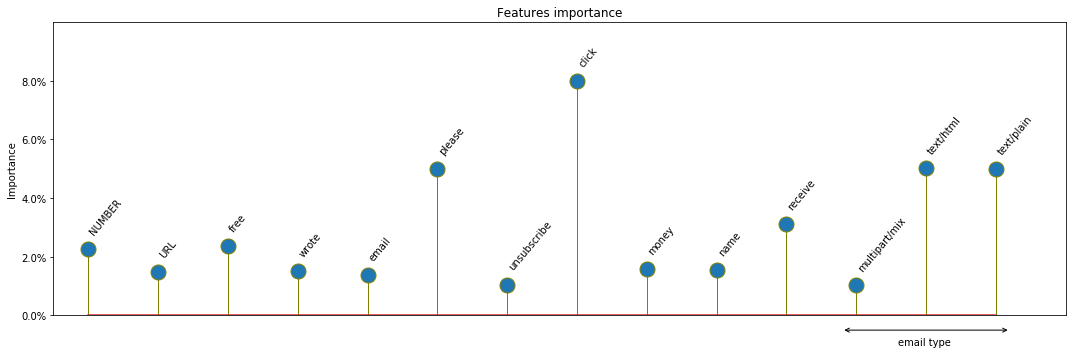

In [60]:
%matplotlib inline

import matplotlib.pyplot as plt

scores = forest_clf['rnd'].feature_importances_
above_1pct_scores = scores[scores>.01]*100

total_feat = forest_clf['pre']['select_features'].total_features    # -> List of the total features used
red_feat_pos = forest_clf['pre']['select_features'].red_feat_list   # -> Position of the reduced set of features
red_feat = total_feat[red_feat_pos]                                 # -> List of the reduced set of features
above_1pct_red_feat = red_feat[np.argwhere(scores>.01)].flatten()   # -> List of the most important features

fig = plt.figure(figsize=(15,5))
ax = plt.axes()
(markers, stemlines, baseline) = ax.stem(list(range(len(above_1pct_scores))),
                                         above_1pct_scores, use_line_collection=True)

plt.setp(markers, marker='o', markersize=15, markeredgecolor="olive", markeredgewidth=1)
plt.setp(stemlines, linestyle="-", color="olive", linewidth=1)


# x - axis
ax.axes.get_xaxis().set_visible(False)
ax.axes.set_xlim((-.5, len(above_1pct_scores)))

# y - axis
y_max = max(above_1pct_scores)+2
ax.axes.set_ylim((0, y_max))
old_ticks = ax.axes.get_yticks()
ticks_labels = ['{}%'.format(digit) for digit in old_ticks]
ax.axes.set_yticklabels(ticks_labels)
ax.axes.set_ylabel('Importance')
ax.axes.set_title('Features importance')

ax.annotate('', xy=(10.8, -.5), xytext=(13.2,-.5),
            arrowprops=dict(arrowstyle='<->', facecolor='red'),
            annotation_clip=False)

ax.annotate('email type', xy=(11.6, -1), annotation_clip=False)

for index, feature in enumerate(above_1pct_red_feat):
    ax.annotate(feature, xy=(index, above_1pct_scores[index]+.5), annotation_clip=False, rotation=50)

save_fig('feature_importances')
plt.show()

### 5.3 Data Clustering

Let's see how the e-mails dispose in the space of the most important features. 
Use the __t-SNE__ to reduce the dimensionality of the space.

In [65]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.base import clone

pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])

forest_prep = clone(forest_clf['pre'])
X_prep_forest = forest_prep.fit_transform(X_train_prepared)

X_pca_tsne_reduced = pca_tsne.fit_transform(X_prep_forest)

Saving figure clustering


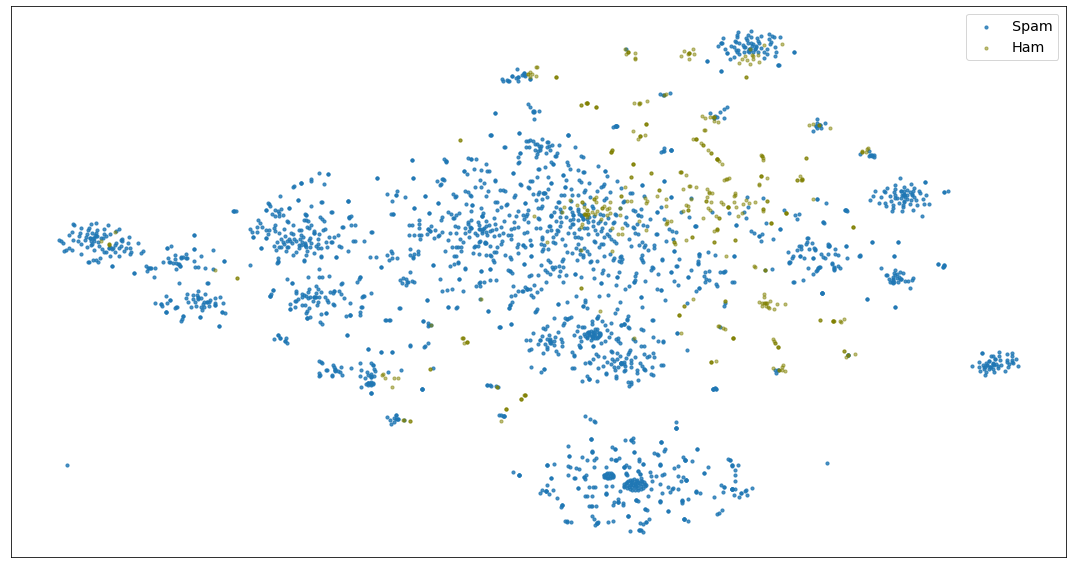

In [66]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

sne_ham = ax.scatter(X_pca_tsne_reduced[y_train==0][:,0], X_pca_tsne_reduced[y_train==0][:, 1], s=10, alpha=.8)
sne_ham.set_label('Spam')

sne_hspam = ax.scatter(X_pca_tsne_reduced[y_train==1][:,0], 
                       X_pca_tsne_reduced[y_train==1][:, 1], 
                       c='olive', s=10, alpha=.5)
sne_hspam.set_label('Ham')

ax.legend(fontsize='x-large')

save_fig('clustering')
plt.show()